# Explore ridge training using theoretical Rand-Sig kernel

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Ridge

from aux import get_flow
from kernels import make_psi_rand_sgm, make_ker_rand_sgm_theory
from disp import set_plot, colors, quiver

In [2]:
# hparams
D = 2
RX = np.linspace(-1.5, 1.5, 12)  # make sure not to include 0 point, since this has no angle associated
DX = np.mean(np.diff(RX))/2

# base system params
TAU = np.array(.01)
B = np.eye(D)
f_base = lambda x: np.zeros(D)
F_base = lambda x, u: (1/TAU)*(-x + f_base(x) + B@u)
flow_base = get_flow(F_base, RX, u=None)

# control directions
C = np.array([
    [1., 0],
    [0,  1],
])  #L   U

# kernel
N = 2000
G = 100
J_PSI = G*np.random.randn(N, D)

psi_name = 'rand_sig'
psi, ker = make_psi_rand_sgm(J_PSI)
# ker = make_ker_rand_sgm_theory()

def ker_vmap(xs, y):
    k_mat = np.nan*np.zeros((len(xs),))
    for cx, x in enumerate(xs):
        k_mat[cx] = ker(x, y)
    return k_mat

def eval_F(x, u, x_stars, alphas):
    
    df = C@alphas.T@ker_vmap(x_stars, x)
    
    return (1/TAU)*(-x + f_base(x) + B@u + df)

In [3]:
def train(data, x_stars, lam=1e-8):
    """Find alphas using Ridge regression."""
    xs = data[:, :D]
    vs = data[:, D:2*D]
    us = data[:, 2*D:]
    
    # make ys
    f_base_vals = np.array([f_base(x) for x in xs])
    Bus = np.array([B@u for u in us])
    
    ys = TAU*vs + xs - f_base_vals - Bus
    
    # make K
    K = np.array([ker_vmap(xs, x_star) for x_star in x_stars]).T
    
    # find best alphas
    rgr = Ridge(alpha=lam, fit_intercept=False)
    alphas = rgr.fit(K, ys).coef_.T
    return alphas

### Support states

In [4]:
n_star = 100
theta_stars = np.linspace(0, 2*np.pi, n_star, endpoint=False)
r_stars = np.random.uniform(.5, 2, n_star)
x_stars = (np.array([np.cos(theta_stars), np.sin(theta_stars)])*r_stars).T

### Radially invariant flow field change

In [5]:
f_theta = lambda theta: 2*np.cos(theta - np.pi/4)+np.sin(5*(theta - 2/3*np.pi))

xs = []
vs = []
us = []

f_base_mat = np.nan*np.zeros((len(RX), len(RX), D))
df_mat = np.nan*np.zeros((len(RX), len(RX), D))
v_mat = np.nan*np.zeros((len(RX), len(RX), D))

for cx_0, x_0 in enumerate(RX):
    for cx_1, x_1 in enumerate(RX):
        
        x = np.array([x_0, x_1])
        theta = np.arctan2(x[1], x[0])

        f_base_ = f_base(x)
        
        df = np.array([f_theta(theta), 0])
        v = (1/TAU)*(-x + f_base_ + df)

        df_mat[cx_0, cx_1, :] = df
        v_mat[cx_0, cx_1, :] = v

        xs.append(x)
        vs.append(v)
        us.append(np.zeros(D))

xs = np.array(xs)
vs = np.array(vs)
us = np.array(us)

data = np.concatenate([xs, vs, us], axis=1)
lam = 1e-8

alphas = train(data, x_stars, lam)

F_POST = lambda x, u: eval_F(x, u, x_stars, alphas)
v_hat_mat = get_flow(F_POST, RX, u=None)

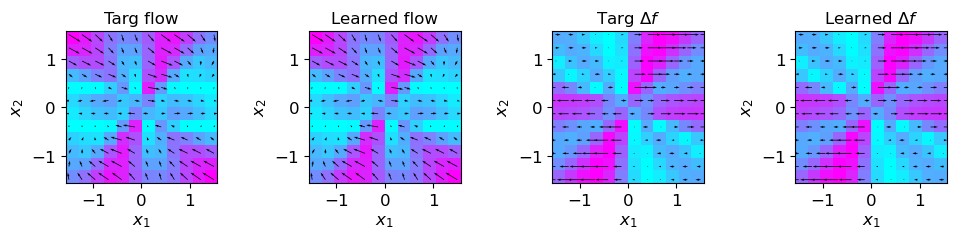

In [6]:
dflow = v_mat - flow_base
dflow_hat = v_hat_mat - flow_base

fig, axs = plt.subplots(1, 4, figsize=(10, 2.5), tight_layout=True)

axs[0].matshow(
    np.linalg.norm(v_mat, axis=2).T, origin='lower', cmap='cool',
    extent=[RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2])
quiver(axs[0], v_mat, RX)
axs[0].xaxis.tick_bottom()
set_plot(axs[0], x_label=r'$x_1$', y_label=r'$x_2$', title='Targ flow')

axs[1].matshow(
    np.linalg.norm(v_hat_mat, axis=2).T, origin='lower', cmap='cool',
    extent=[RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2])
quiver(axs[1], v_hat_mat, RX)
axs[1].xaxis.tick_bottom()
set_plot(axs[1], x_label=r'$x_1$', y_label=r'$x_2$', title='Learned flow')

axs[2].matshow(
    np.linalg.norm(dflow, axis=2).T, origin='lower', cmap='cool',
    extent=[RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2])
quiver(axs[2], dflow, RX)
axs[2].xaxis.tick_bottom()
set_plot(axs[2], x_label=r'$x_1$', y_label=r'$x_2$', title=r'Targ $\Delta f$')

axs[3].matshow(
    np.linalg.norm(dflow_hat, axis=2).T, origin='lower', cmap='cool',
    extent=[RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2])
quiver(axs[3], dflow_hat, RX)
axs[3].xaxis.tick_bottom()
set_plot(axs[3], x_label=r'$x_1$', y_label=r'$x_2$', title=r'Learned $\Delta f$')

fig.savefig(f'ms/s1_rand_sig_thry_radially_inv_g_{G}.svg')

### Radially varying flow field change

In [7]:
xs = []
vs = []
us = []

f_base_mat = np.nan*np.zeros((len(RX), len(RX), D))
df_mat = np.nan*np.zeros((len(RX), len(RX), D))
v_mat = np.nan*np.zeros((len(RX), len(RX), D))

for cx_0, x_0 in enumerate(RX):
    for cx_1, x_1 in enumerate(RX):
        
        x = np.array([x_0, x_1])
        theta = np.arctan2(x[1], x[0])

        f_base_ = f_base(x)
        
        df = np.array([np.cos(2*x_1), 0])
        v = (1/TAU)*(-x + f_base_ + df)

        df_mat[cx_0, cx_1, :] = df
        v_mat[cx_0, cx_1, :] = v

        xs.append(x)
        vs.append(v)
        us.append(np.zeros(D))

xs = np.array(xs)
vs = np.array(vs)
us = np.array(us)

data = np.concatenate([xs, vs, us], axis=1)
lam = 1e-8

alphas = train(data, x_stars, lam)

F_POST = lambda x, u: eval_F(x, u, x_stars, alphas)
v_hat_mat = get_flow(F_POST, RX, u=None)

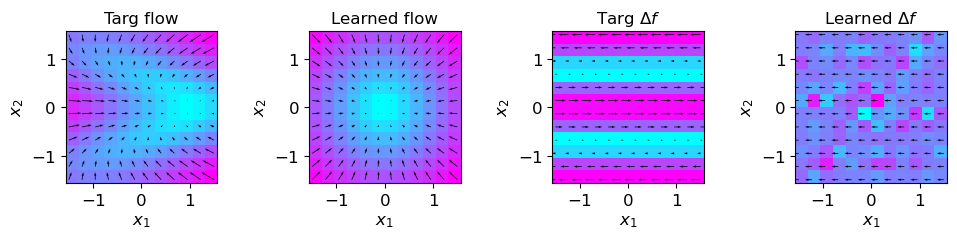

In [8]:
dflow = v_mat - flow_base
dflow_hat = v_hat_mat - flow_base

fig, axs = plt.subplots(1, 4, figsize=(10, 2.5), tight_layout=True)

axs[0].matshow(
    np.linalg.norm(v_mat, axis=2).T, origin='lower', cmap='cool',
    extent=[RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2])
quiver(axs[0], v_mat, RX)
axs[0].xaxis.tick_bottom()
set_plot(axs[0], x_label=r'$x_1$', y_label=r'$x_2$', title='Targ flow')

axs[1].matshow(
    np.linalg.norm(v_hat_mat, axis=2).T, origin='lower', cmap='cool',
    extent=[RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2])
quiver(axs[1], v_hat_mat, RX)
axs[1].xaxis.tick_bottom()
set_plot(axs[1], x_label=r'$x_1$', y_label=r'$x_2$', title='Learned flow')

axs[2].matshow(
    np.linalg.norm(dflow, axis=2).T, origin='lower', cmap='cool',
    extent=[RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2])
quiver(axs[2], dflow, RX)
axs[2].xaxis.tick_bottom()
set_plot(axs[2], x_label=r'$x_1$', y_label=r'$x_2$', title=r'Targ $\Delta f$')

axs[3].matshow(
    np.linalg.norm(dflow_hat, axis=2).T, origin='lower', cmap='cool',
    extent=[RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2])
quiver(axs[3], dflow_hat, RX)
axs[3].xaxis.tick_bottom()
set_plot(axs[3], x_label=r'$x_1$', y_label=r'$x_2$', title=r'Learned $\Delta f$')

fig.savefig(f'ms/s1_rand_sig_thry_radially_var_g_{G}.svg')